In [2]:
import keras
import librosa
import python_speech_features
from scipy.io import wavfile
import numpy as np
from timeit import default_timer as timer
from pathlib import Path
import IPython.display as ipd
from pydub import AudioSegment

def get_audio(path, sample_rate=16000):
    wav, wav_sr = librosa.load(path, sr=sample_rate)
    if wav.size < 16000:
        return np.pad(wav, (16000 - wav.size, 0), mode='constant')
    else:
        return wav[0:16000]

# compute MFCC features from audio signal
def audio2feature(audio):
    audio = audio.astype(np.float)
    # normalize data
    audio -= audio.mean()
    audio /= np.max((audio.max(), -audio.min()))
    # compute MFCC coefficients
    features = python_speech_features.mfcc(audio, samplerate=16000, winlen=0.025, winstep=0.01, numcep=20, nfilt=40,
                                           nfft=512, lowfreq=100, highfreq=None, preemph=0.97, ceplifter=22,
                                           appendEnergy=True, winfunc=np.hamming)
    return features

def extract_loudest_section(audio, length):
    audio = audio[:, 0].astype(np.float) # to avoid integer overflow when squaring
    audio_pw = audio**2 # power
    window = np.ones((length, ))
    conv = np.convolve(audio_pw, window, mode="valid")
    begin_index = conv.argmax()
    return audio[begin_index:begin_index+length]


def signaltonoise(command, noise):
    c = np.mean(command)
    n = np.mean(noise)

    return np.abs(c / n)


def get_nr_noises(path, samples_nr):
    ''' Returns paths to noise samples.'''
    datadir = Path(path)
    files = [str(f) for f in datadir.glob('**/*.wav') if f]
    return files[0:samples_nr]

Using TensorFlow backend.


KeyboardInterrupt: 

In [ ]:
wav = get_audio('data_new/training/bed/0c2ca723_nohash_1.wav')
bg = get_audio('noise/a001_80_90.wav')
start_ = np.random.randint(bg.shape[0]-16000)
bg_slice = bg[start_ : start_+16000]
wav_with_bg = wav * np.random.uniform(0.8, 1.2) + \
              bg * np.random.uniform(0, 1)

librosa.output.write_wav(path="output2.wav", y=wav_with_bg, sr=16000 )
 

from playsound import playsound

playsound("output2.wav")

In [ ]:
from IPython.display import clear_output
from tensorflow import keras

audio_buffer = np.zeros((5, 3200))
last_recognized_word = None
last_recognition_time = 0
recognition_timeout = 1.0
word2index = {
    # core words
    "yes": 0,
    "no": 1,
    "up": 2,
    "down": 3,
    "left": 4,
    "right": 5,
    "on": 6,
    "off": 7,
    "stop": 8,
    "go": 9,
    "unknown": 10
}
index2word = [word for word in word2index]
model = keras.models.load_model("models/model_January_16/model.11.hdf5")

def audio_stream_callback(indata, frames, time, status):
    global audio_buffer
    global model
    global index2word
    global last_recognized_word
    global last_recognition_time
    audio_buffer = np.roll(audio_buffer, shift=-1, axis=0)
    audio_buffer[-1, :] = np.squeeze(indata)
    recorded_feature = audio2feature(audio_buffer.flatten())
    recorded_feature = np.expand_dims(recorded_feature, 0) # add "fake" batch dimension 1
    prediction = model.predict(recorded_feature).reshape((11, ))
    # normalize prediction output to get "probabilities"
    prediction /= prediction.sum()
    best_candidate_index = prediction.argmax()
    best_candidate_probability = prediction[best_candidate_index]
    
    if(best_candidate_probability > 0.5): # treshold
        word = index2word[best_candidate_index]
        if( (timer()-last_recognition_time)>recognition_timeout or word!=last_recognized_word ):
            last_recognition_time = timer()
            last_recognized_word = word
            clear_output(wait=True) # clear ouput as soon as new output is available to replace it
            print("%s\t:\t%2.1f%%" % (word, best_candidate_probability*100))
            print("-----------------------------")


In [ ]:
import sounddevice as sd
# REALTIME KEYWORD RECOGNITION DEMO (60s long)
with sd.InputStream(samplerate=16000, blocksize=3200, device=None, channels=1, dtype="float32", callback=audio_stream_callback):
    sd.sleep(60*1000)


In [1]:
import matplotlib
import numpy as np
import librosa
from tensorflow import keras
from pathlib import Path
from tqdm import tqdm
# %matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
from scipy import signal


def get_audio(path, sample_rate=16000):
    wav, wav_sr = librosa.load(path, sr=sample_rate)
    if wav.size < 16000:
        return np.pad(wav, (16000 - wav.size, 0), mode='constant')
    else:
        return wav[0:16000]

word2index = {
    # core words
    "yes": 0,
    "no": 1,
    "up": 2,
    "down": 3,
    "left": 4,
    "right": 5,
    "on": 6,
    "off": 7,
    "stop": 8,
    "go": 9,
    "unknown": 10
}

def signaltonoise(command, noise):
    c = np.mean(command)
    n = np.mean(noise)

    return np.abs(c / n)

def get_noise_audio(path, sample_rate=16000):
    wav, wav_sr = librosa.load(path, sr=sample_rate)
    return wav


def get_nr_noises(path, samples_nr):
    ''' Returns paths to noise samples.'''
    datadir = Path(path)
    files = [str(f) for f in datadir.glob('**/*.wav') if f]
    return files[0:samples_nr]

def get_data(path):
    ''' Returns dataframe with columns: 'path', 'word'.'''
    datadir = Path(path)
    files = [(str(f), f.parts[-2]) for f in datadir.glob('**/*.wav') if f]
    df = pd.DataFrame(files, columns=['path', 'word'])

    return df


def prepare_data(df):
    '''Transform data into something more useful.'''
    train_words = ['yes', 'no', 'up', 'down',
                   'left', 'right', 'on', 'off', 'stop', 'go']

    df.loc[~df.word.isin(train_words), 'word'] = 'unknown'
    return df

def get_specgram(audio):
    data = signal.spectrogram(audio, nperseg=256, noverlap=128)[2]
    # print(data.shape)
    return data

def get_cut_noise_audio(noise):
    noise = get_noise_audio(noise)
    return noise[0:16000]

def add_noise(command, noise, command_i=None, noise_i=None):
    if noise_i is None:
        noise_i = np.random.uniform(0, 2.0)
    if command_i is None:
        command_i = np.random.uniform(0.8, 1.2)
    wav_with_bg = command * command_i + noise * noise_i

    return wav_with_bg


index2word = [word for word in word2index]
print(index2word)

print("loading dataset...")
# train = prepare_data(get_data('/macierz/home/s165554/pg/szum/data/evaluation/'))
test = prepare_data(get_data('../data/equal/evaluation'))
test_size = len(test)
noises = get_nr_noises("../data/noise", len(test))
noise_size = len(noises)
#noises = None
#with_noise = False


samples = []
classes = []
snr = []

for class_name in test.word:
    classes.append(word2index[class_name])
classes = np.array(classes, dtype=np.int)
test = np.array(test.path)

d:\a__a\projects\szum\venv\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
d:\a__a\projects\szum\venv\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown']
loading dataset...


In [2]:
from kapre.time_frequency import Melspectrogram, Spectrogram
import kapre

def AttRNNSpeechModel(nCategories, samplingrate=16000,
                      inputLength=16000, rnn_func=keras.layers.LSTM):
    # simple LSTM
    sr = samplingrate
    iLen = inputLength

    inputs = keras.layers.Input((inputLength,), name='input')

    x = keras.layers.Reshape((1, -1))(inputs)

    m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                       padding='same', sr=sr, n_mels=80,
                       fmin=40.0, fmax=sr / 2, power_melgram=1.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='mel_stft')
    m.trainable = False

    x = m(x)

    x = kapre.utils.Normalization2D(int_axis=0, name='mel_stft_norm')(x)

    # note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    # we would rather have it the other way around for LSTMs

    x = keras.layers.Permute((2, 1, 3))(x)

    x = keras.layers.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)

    # x = Reshape((125, 80)) (x)
    # keras.backend.squeeze(x, axis)
    x = keras.layers.Lambda(lambda q: keras.backend.squeeze(q, -1), name='squeeze_last_dim')(x)

    x = keras.layers.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]
    x = keras.layers.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]

    xFirst = keras.layers.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    query = keras.layers.Dense(128)(xFirst)

    # dot product attention
    attScores = keras.layers.Dot(axes=[1, 2])([query, x])
    attScores = keras.layers.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # rescale sequence
    attVector = keras.layers.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]

    x = keras.layers.Dense(64, activation='relu')(attVector)
    x = keras.layers.Dense(32)(x)

    output = keras.layers.Dense(nCategories, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[inputs], outputs=[output])

    return model

In [46]:
def get_model(num_classes, shape=(99, 20)):
    model = keras.models.Sequential()

    model.add(keras.layers.Input(shape=shape))

    model.add(keras.layers.Conv1D(64, kernel_size=8, activation="relu", input_shape=shape))
    model.add(keras.layers.MaxPooling1D(pool_size=4))

    model.add(keras.layers.Conv1D(128, kernel_size=8, activation="relu"))

    model.add(keras.layers.Conv1D(256, kernel_size=5, activation="relu"))
    model.add(keras.layers.GlobalMaxPooling1D())

    model.add(keras.layers.Dense(128, activation="relu"))

    model.add(keras.layers.Dense(64, activation="relu"))

    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    #model.summary()
    return model

In [58]:
#model = AttRNNSpeechModel(11)
model = get_model(11, (99, 20))
model.load_weights("models/model_good_adam_lr_decay/model.18.hdf5")
#model = keras.models.load_model("models/model_good_adam_lr_decay/model.29.hdf5")
#model.load_weights("models/model_AttRNN/model.14.hdf5")
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 92, 64)            10304     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16, 128)           65664     
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 12, 256)           164096    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_34 (Dense)             (None, 64)               

In [4]:
samples = []
noise_sample = []

for id, path in enumerate(tqdm(test)):
    noise_sample.append(get_cut_noise_audio(noises[id % noise_size]))
    samples.append(get_audio(path))

samples = np.array(samples)
noise_sample = np.array(noise_sample)


100%|██████████| 2570/2570 [27:41<00:00,  1.55it/s]


In [ ]:
samples_with_noise = []
#ratios = {5.0, 4.0, 3.0, 2.0, 1.0, 0.5, 0.33, 0.25, 0.20, 0.16, 0.14}
ratios = {5.0, 4.0, 3.0, 2.0, 1.0, 0.5, 0.33, 0.25, 0.20, 0.16, 0.14, 0.125, 0.11, 0.1}
#ratios = {5.0}
#snr_ratio = 2.0
for snr_ratio in ratios:
    samples_with_noise = []
    for id, audio in enumerate(tqdm(samples)):
        c = np.mean(audio)
        n = np.mean(noise_sample[id])
        noise_i = np.abs(c * 1.0 / (n * snr_ratio))
        #snr.append(signaltonoise(audio, noise_sample[id] * noise_i))
        data = add_noise(audio, noise_sample[id], command_i=1.0, noise_i=noise_i)
        data -= data.mean()
        data /= np.max((data.max(), -data.min()))
        samples_with_noise.append(data)
    
    samples_with_noise = np.array(samples_with_noise)
    correct = 0
    predicted = []
    
    for id, rec in enumerate(tqdm(samples_with_noise)):
        rec = audio2feature(rec)
        recorded_feature = np.expand_dims(rec, 0) 
        prediction = model.predict(recorded_feature).reshape((11,))
        prediction /= prediction.sum()
        max_class_id = prediction.argmax()
        predicted.append(max_class_id)
        if index2word[max_class_id] == index2word[classes[id]]:
            correct += 1
    
    acc = correct / len(samples)
    print("SNR = " + str(snr_ratio))
    print("TOP1 acc = " + str(acc))

  7%|▋         | 181/2570 [00:12<02:14, 17.73it/s]

SNR = 0.5
TOP1 acc = 0.7147859922178988
SNR = 1.0
TOP1 acc = 0.7727626459143969
SNR = 2.0
TOP1 acc = 0.8210116731517509


In [57]:
correct = 0
predicted = []

for id, rec in enumerate(tqdm(samples)):
    rec = audio2feature(rec)
    recorded_feature = np.expand_dims(rec, 0) 
    prediction = model.predict(recorded_feature).reshape((11,))
    prediction /= prediction.sum()
    max_class_id = prediction.argmax()
    predicted.append(max_class_id)
    if index2word[max_class_id] == index2word[classes[id]]:
        correct += 1

acc = correct / len(samples)
print("No noise ")
print("TOP1 acc = " + str(acc))
# cm = confusion_matrix(classes, predicted, normalize="all")
# %matplotlib inline
# plt.close()
# plt.figure(figsize = (8,8))
# plt.imshow(cm, cmap=plt.cm.Blues)
# plt.xlabel("Predicted labels")
# plt.ylabel("True labels")
# plt.xticks(np.arange(0, 11, 1), index2word, rotation=90)
# plt.yticks(np.arange(0, 11, 1), index2word)
# plt.tick_params(labelsize=12)
# plt.title('Confusion matrix ')
# plt.colorbar()
# plt.savefig('origin_dataset.png')
# plt.show()

100%|██████████| 2570/2570 [02:57<00:00, 14.46it/s]


No noise 
TOP1 acc = 0.9252918287937744


In [ ]:
print(predicted)

(129, 124)
(99, 161)
(99, 20)


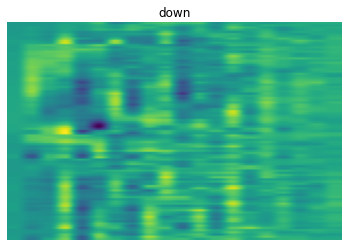

In [43]:
import tensorflow as tf
import python_speech_features
import numpy as np

def get_specgram(audio):
    data = signal.spectrogram(audio, nperseg=256, noverlap=128)[2]
    # print(data.shape)
    return data


def get_melspecgram(audio):
    data = librosa.feature.melspectrogram(audio)
    # print(data.shape)
    return data


def get_stft(audio):
    spectrogram = tf.abs(tf.signal.stft(audio, frame_length=255, frame_step=128))
    return spectrogram


def get_spectrogram_shape(function, audio_path):
    wav = get_audio(audio_path)
    data = function(wav)
    return data.shape

def log_specgram(audio, sample_rate=16000, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return np.log(spec.T.astype(np.float32) + eps)

def audio2feature(audio):
    audio = audio.astype(np.float)
    # normalize data
    audio -= audio.mean()
    audio /= np.max((audio.max(), -audio.min()))
    # compute MFCC coefficients
    features = python_speech_features.mfcc(audio, samplerate=16000, winlen=0.025, winstep=0.01, numcep=20, nfilt=40,
                                           nfft=512, lowfreq=100, highfreq=None, preemph=0.97, ceplifter=22,
                                           appendEnergy=True, winfunc=np.hamming)
    return features

wav = get_audio("../data/data_new/training/yes/0a7c2a8d_nohash_0.wav")
spec = get_specgram(wav)
print(spec.shape)
plt.title("yes")
plt.imshow(spec, aspect='auto', origin='lower')
plt.axis('off')
plt.savefig('spec_yes.png')

wav = get_audio("../data/data_new/training/no/0a9f9af7_nohash_0.wav")
spec = log_specgram(wav)
#spec = np.transpose(spec)
print(spec.shape)
plt.title("no")
plt.imshow(spec, aspect='auto', origin='lower')
plt.axis('off')
plt.savefig('log_no.png')

wav = get_audio("../data/data_new/training/down/0a7c2a8d_nohash_0.wav")
spec = audio2feature(wav)
print(spec.shape)
plt.title("down")
plt.imshow(spec, aspect='auto', origin='lower')
plt.axis('off')
plt.savefig('log_down.png')

